# Creating a lightcurve model in LightCurveLynx with BAGLE
Natasha Abrams and Katarzyna Kruszynska
11-13-25

This method produces a high sampled model in [BAGLE](https://github.com/MovingUniverseLab/bagle_microlensing) and resamples it with LightCurveLynx with Rubin cadence and noise. It has an example with PSPL and PSBL. The specific parameterizations chosen is to be compatable with the output tables from PopSyCLE, but there are many other BAGLE parameterizations with more traditional microlensing parameters.

Based on this notebook on doing this with pyLIMA https://github.com/LSST-TVSSC/microlensing/blob/main/lightcurvelynx_simulations/lightcurvelynx_pyLIMA.ipynb

## Imports

In [17]:
import lsdb  # To get Rubin data

from lightcurvelynx.astro_utils.mag_flux import flux2mag, mag2flux  # AB mags <-> nJy
from lightcurvelynx.astro_utils.passbands import PassbandGroup  # Filter transmissions
from lightcurvelynx.base_models import FunctionNode  # Define custom parameter samplers
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc  # Parameter sampling with numpy.random
from lightcurvelynx.math_nodes.ra_dec_sampler import ObsTableUniformRADECSampler # Sky position sampling
from lightcurvelynx.obstable.opsim import OpSim  # Deal with LSST cadence and noise simulations
from lightcurvelynx.simulate import simulate_lightcurves
from lightcurvelynx.models.lightcurve_template_model import LightcurveTemplateModel

In [10]:
from bagle import model

<frozen importlib._bootstrap>:488: FutureWarning: pybind11-bound class 'celerite.solver.CholeskySolver' is using an old-style placement-new '__setstate__' which has been deprecated. See the upgrade guide in pybind11's docs. This message is only visible when compiled in debug mode.


In [11]:
# Other packages
import matplotlib.pyplot as plt  # For plots
import numpy as np  # For math
import pandas as pd  # For tabular data

from astropy import units as u
from astropy.coordinates import SkyCoord

## Create a model with BAGLE - PSPL

In [51]:
# Hard-coded coordinates of the event

raL, decL =  270.66679, -35.70483
muL, muS = [5, 10], [0, 0]
            
model_name = 'PSPL_PhotAstrom_Par_Param1'

mL = 1  # Msun (Primary lens current mass)
t0 = 61800  # mjd
xS0 = np.array([0, 0])  # arbitrary offset (arcsec)
beta = 0.1
dL = 4000 # Distance to lens
dS = 8000 # Distance to source
mag_src = [23, 22, 21.5, 21, 20.5, 19.5]
b_sff = [1, 1, 1, 1, 1, 1]

parameter_dict = {'raL': raL, 'decL': decL, 'mL': mL,
                  't0': t0, 'beta': beta, 'dL': dL, 'dL_dS': dL / dS,
                  'xS0_E': xS0[0], 'xS0_N': xS0[1],
                  'muL_E': muL[0], 'muL_N': muL[1], 'muS_E': muS[0], 'muS_N': muS[1],
                  'b_sff': b_sff, 'mag_src': mag_src}
mod_class = getattr(model, model_name)
mod = mod_class(**parameter_dict)

In [52]:
# Simulate an very high sampling light curve for this event
time_grid = np.arange(0, 10000., 0.1)
# Adding a constant shift to simulate parallax properly
time_grid += 60500.0

In [53]:
LSST_id_u =mod.get_photometry(time_grid, 0)
LSST_id_g =mod.get_photometry(time_grid, 1)
LSST_id_r =mod.get_photometry(time_grid, 2)
LSST_id_i =mod.get_photometry(time_grid, 3)
LSST_id_z =mod.get_photometry(time_grid, 4)
LSST_id_y =mod.get_photometry(time_grid, 5)

## Trasforming an event to a light curve grid

NOTE: In here I sample from the ideal microlensing event light curve. This approach can be used to sample from any ideal light curve we have. While this is not the suggested way to simulate light curves with `LightCurveLynx`, it can be used for variables for which we don't have a good theoretical model. 

[**This notebook**](https://github.com/LSST-TVSSC/microlensing/blob/tdastro_notebooks/tdastro_microlensing/tdastro_microlens_vblensing.ipynb) shows the suggested way of creating microlensing events, but Katarzyna switched there to VBMicrolensing. This will be also a part of LightCurveLynx in the future.

In [54]:
# Expected input for LightCurveLynx
time_stamps = time_grid

# light curve grid dictionary
lightcurve_grid = {
    'u': np.stack([time_stamps,
                   mag2flux(LSST_id_u)],
                   axis=-1),
    'g': np.stack([time_stamps, 
                   mag2flux(LSST_id_g)],
                   axis=-1
                 ),
    'r': np.stack([time_stamps,
                   mag2flux(LSST_id_r)],
                   axis=-1
                 ),
    'i': np.stack([time_stamps,
                   mag2flux(LSST_id_i)],
                   axis=-1
                 ),
    'z': np.stack([time_stamps,
                   mag2flux(LSST_id_z)],
                   axis=-1
                 ),
    'y': np.stack([time_stamps,
                   mag2flux(LSST_id_y)],
                   axis=-1
                 ),
    
}

# Grabbing OpSim

In [44]:
# baseline 5.0 selected here. You can either pull it from a url or download it and access it from a predownloaded db

#opsim_url = "https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs5.0/baseline//baseline_v5.0.0_10yrs.db"
#opsim_data = OpSim.from_url(opsim_url)

opsim_data = OpSim.from_db('/u/nsabrams/work/rubin/OpSim/baseline_v5.0.0_10yrs.db')

In [45]:
# Time offset
lightcurve_t0 = 61100.0 # has to be in MJD (OpSim is in MJD)

# LSST Pabssands
lsst_passbands = PassbandGroup.from_preset("LSST", table_dir='/u/nsabrams/work/rubin/') #not required to specific table_dir, default is install location

## Simulating event with LightCurveLynx

In [55]:
lightcurve_source = LightcurveTemplateModel(
    lightcurves=lightcurve_grid,
    passbands=lsst_passbands,
    periodic=False,
    t0=mod.t0,
    ra=raL,
    dec=decL,
    lc_data_t0=mod.t0
)

In [56]:
# I will simulate a single light curve
tda_simulation = simulate_lightcurves(lightcurve_source, 1, opsim_data, lsst_passbands)

Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 243.08obj/s]


In [57]:
# The output is in a nested pandas table
tda_simulation

id         ra       dec  nobs     t0     z  \
0   0  270.66679 -35.70483   827  61800  None   

                                              params  \
0  {'LightcurveTemplateModel_0.ra': 270.66679, 'L...   

                                          lightcurve  
0  [{mjd: 60996.021132, filter: 'i', flux: 13953....

In [58]:
# Extracting the light curve
simulated_lightcurve = tda_simulation["lightcurve"].iloc[0]

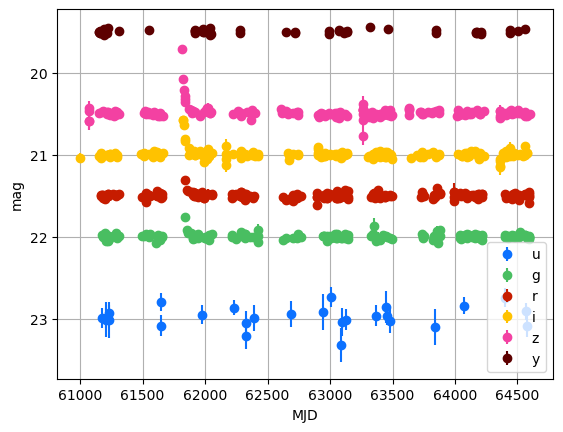

In [59]:
# It is time to plot our event
def flux_to_mag_df(df):
    df = df.copy()
    df = df.query("flux > 0")
    df["mag"] = flux2mag(df["flux"])
    df["magerr"] = 2.5 / np.log(10) * df["fluxerr"] / df["flux"]
    df["band"] = df["filter"]
    return df

COLORS = {
    "u": "#0c71ff",
    "g": "#49be61",
    "r": "#c61c00",
    "i": "#ffc200",
    "z": "#f341a2",
    "y": "#5d0000",
    "zg": "#62D03E",
    "zr": "#CC3344",
}


def plot_lc(df, period=None):
    df = df.copy()
    if period is not None and "phase" not in df.columns:
        mjd_min_light = df["mjd"][df.query("band == 'r'")["mag"].idxmax()]
        df["phase"] = (df["mjd"] - mjd_min_light) % period / period
    if period is None:
        x_col = "mjd"
    else:
        x_col = "phase"
    plt.figure()
    if len({"zg", "zr"} & set(df["band"])) > 0:
        for band in ["zg", "zr"]:
            data = df.query("band == @band")
            plt.errorbar(
                data[x_col],
                data["mag"],
                yerr=data["magerr"],
                label=f"{band}",
                fmt="o",
                color=COLORS[band],
                alpha=0.2,
            )
    for band in "ugrizy":
        data = df.query("band == @band")
        plt.errorbar(
            data[x_col], data["mag"], yerr=data["magerr"], label=f"{band}", fmt="o", color=COLORS[band]
        )

    plt.gca().invert_yaxis()
    if period is None:
        plt.xlabel("MJD")
    else:
        plt.xlabel("phase")
        plt.xlim([0, 1])
        plt.title(f"{period = } d")
    plt.ylabel("mag")
    plt.legend(loc="lower right")
    plt.grid(True)
    # plt.ylim(30, 0)
    
mag_sim_lightcurve = flux_to_mag_df(simulated_lightcurve)
plot_lc(mag_sim_lightcurve, period=None)

## Create a model with BAGLE - PSBL

In [103]:
model_name = 'PSBL_PhotAstrom_Par_EllOrbs_Param7'

raL, decL =  270.66679, -35.70483
muL, muS = [5, 10], [0, 0]

mLp = 10  # msun (Primary lens current mass)
mLs = 5  # msun (Companion lens current mass)
t0_p = 62000  # mjd
xS0 = np.array([0, 0])  # arbitrary offset (arcsec)
beta_p = 0.1
dL = 4000 # Distance to lens
dS = 8000 # Distance to source
mag_src = [23, 22, 21.5, 21, 20.5, 19.5]
b_sff = [1, 1, 1, 1, 1, 1]
omega = 10
big_omega = 10
i = 0
e = 0.9
tp = 61800
a = 0.5
dmag_Lp_Ls = [2, 2, 2, 2, 2, 2]


parameter_dict = {'raL': raL, 'decL': decL,
                  'mLp': mLp, 'mLs': mLs, 't0_p': t0_p,
                  'xS0_E': xS0[0], 'xS0_N': xS0[1], 'beta_p': beta_p,
                  'muL_E': muL[0], 'muL_N': muL[1], 'muS_E': muS[0], 'muS_N': muS[1],
                  'dL': dL, 'dS': dS, 
                  #'sep': sep, 'alpha': alpha, 
                  'mag_src': mag_src, 'b_sff': b_sff, 'omega_pri': omega, 'big_omega_sec': big_omega,
                 'i': i, 'e': e, 'tp': tp, 'a': a, 'dmag_Lp_Ls': dmag_Lp_Ls}

mod_class = getattr(model, model_name)
mod = mod_class(**parameter_dict)

In [104]:
# Simulate an very high sampling light curve for this event
time_grid = np.arange(0, 10000., 0.1)
# Adding a constant shift to simulate parallax properly
time_grid += 60500.0

In [105]:
LSST_id_u =mod.get_photometry(time_grid, 0)
LSST_id_g =mod.get_photometry(time_grid, 1)
LSST_id_r =mod.get_photometry(time_grid, 2)
LSST_id_i =mod.get_photometry(time_grid, 3)
LSST_id_z =mod.get_photometry(time_grid, 4)
LSST_id_y =mod.get_photometry(time_grid, 5)

In [106]:
# Expected input for LightCurveLynx
time_stamps = time_grid

# light curve grid dictionary
lightcurve_grid = {
    'u': np.stack([time_stamps,
                   mag2flux(LSST_id_u)],
                   axis=-1),
    'g': np.stack([time_stamps, 
                   mag2flux(LSST_id_g)],
                   axis=-1
                 ),
    'r': np.stack([time_stamps,
                   mag2flux(LSST_id_r)],
                   axis=-1
                 ),
    'i': np.stack([time_stamps,
                   mag2flux(LSST_id_i)],
                   axis=-1
                 ),
    'z': np.stack([time_stamps,
                   mag2flux(LSST_id_z)],
                   axis=-1
                 ),
    'y': np.stack([time_stamps,
                   mag2flux(LSST_id_y)],
                   axis=-1
                 ),
    
}

In [107]:
lightcurve_source = LightcurveTemplateModel(
    lightcurves=lightcurve_grid,
    passbands=lsst_passbands,
    periodic=False,
    t0=mod.t0,
    ra=raL,
    dec=decL,
    lc_data_t0=mod.t0
)

In [108]:
# I will simulate a single light curve
tda_simulation = simulate_lightcurves(lightcurve_source, 1, opsim_data, lsst_passbands)

Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 239.51obj/s]


In [109]:
# Extracting the light curve
simulated_lightcurve = tda_simulation["lightcurve"].iloc[0]

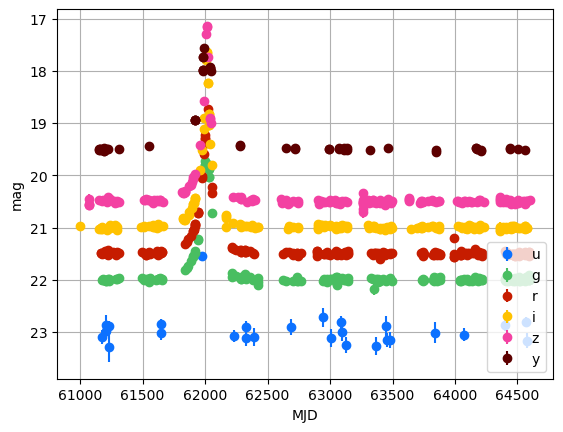

In [113]:
mag_sim_lightcurve = flux_to_mag_df(simulated_lightcurve)
plot_lc(mag_sim_lightcurve, period=None)

(61500.0, 62500.0)

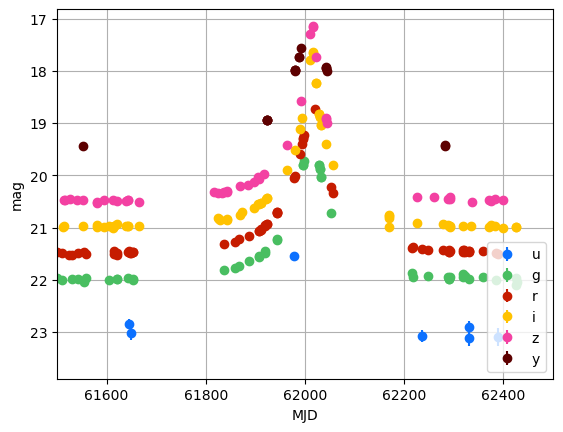

In [114]:
mag_sim_lightcurve = flux_to_mag_df(simulated_lightcurve)
plot_lc(mag_sim_lightcurve, period=None)
plt.xlim(61500, 62500)